#  Anomaly detection in network traffic

In [142]:
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
%matplotlib inline
from plotly.graph_objs import *
# plotly.offline.init_notebook_mode()
# plotly.tools.set_credentials_file(username='AARTURI', api_key='qiQqOxKJXDlziMFzaB8j')
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime

## Features created from pcap (Wireshark)

In [143]:
cols = ["Number","Time","Source","Destination","Protocol","Length","Host","Destination Port","Source Port","Time_delta","Info","Bytes transfer","DateTime", "label"]

In [144]:

dfWireshark1 = pd.read_csv("dataset_wireshark" , sep=",", names=cols , index_col=None)
dfWireshark2 = pd.read_csv("dataset_wireshark2", sep=",", names=cols , index_col=None)
dfWireshark3 = pd.read_csv("dataset_wireshark3", sep=",", names=cols , index_col=None)
dfWireshark4 = pd.read_csv("dataset_selfgenerated", sep=",", names=cols , index_col=None)
dfWireshark = pd.concat([dfWireshark1, dfWireshark2, dfWireshark3, dfWireshark4], axis=0, join='inner').reset_index(drop=True)
dfWireshark = dfWireshark.drop("Number", axis = 1)
dfWireshark.to_csv("final_dataset")

/home/acer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (0,1,5,7,8,9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [145]:
dfWireshark.head(10)

,Time,Source,Destination,Protocol,Length,Host,Destination Port,Source Port,Time_delta,Info,Bytes transfer,DateTime,label
0,0,172.16.4.1,172.16.4.193,DHCP,348,NaN,68,67,0,DHCP ACK - Transaction ID 0x39132272,348,"2017-01-27 19:53:08,210137",NaN
1,0.008974,172.16.4.193,224.0.0.252,LLMNR,69,NaN,5355,57650,0.008974,Standard query 0xf14f ANY Stewie-PC,69,"2017-01-27 19:53:08,219111",NaN
2,0.107795,172.16.4.193,224.0.0.252,LLMNR,69,NaN,5355,57650,0.098821,Standard query 0xf14f ANY Stewie-PC,69,"2017-01-27 19:53:08,317932",NaN
3,1.52807,172.16.4.193,224.0.0.252,LLMNR,66,NaN,5355,61613,1.42027,Standard query 0x8280 A isatap,66,"2017-01-27 19:53:09,738207",NaN
4,1.63662,172.16.4.193,224.0.0.252,LLMNR,66,NaN,5355,61613,0.108548,Standard query 0x8280 A isatap,66,"2017-01-27 19:53:09,846755",NaN
5,2.06019,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.423573,Release NB STEWIE-PC<20>,110,"2017-01-27 19:53:10,270328",NaN
6,2.06039,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.000197,Release NB WORKGROUP<00>,110,"2017-01-27 19:53:10,270525",NaN
7,2.0604,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,8e-06,Release NB STEWIE-PC<00>,110,"2017-01-27 19:53:10,270533",NaN
8,2.13618,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.075783,Registration NB STEWIE-PC<00>,110,"2017-01-27 19:53:10,346316",NaN
9,2.13638,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.000198,Registration NB WORKGROUP<00>,110,"2017-01-27 19:53:10,346514",NaN


## Preprocessing data

In [146]:
dfWireshark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100101 entries, 0 to 100100
Data columns (total 13 columns):
Time                100101 non-null object
Source              100101 non-null object
Destination         100101 non-null object
Protocol            100101 non-null object
Length              100101 non-null object
Host                229 non-null object
Destination Port    2533 non-null object
Source Port         2533 non-null object
Time_delta          100101 non-null object
Info                100101 non-null object
Bytes transfer      100101 non-null object
DateTime            100101 non-null object
label               0 non-null float64
dtypes: float64(1), object(12)
memory usage: 9.9+ MB


In [147]:
#Dense calculation, transforming date timestamps
dfWireshark['DateTime'] = pd.to_datetime(dfWireshark.DateTime,  errors='coerce')


In [148]:
dfWireshark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100101 entries, 0 to 100100
Data columns (total 13 columns):
Time                100101 non-null object
Source              100101 non-null object
Destination         100101 non-null object
Protocol            100101 non-null object
Length              100101 non-null object
Host                229 non-null object
Destination Port    2533 non-null object
Source Port         2533 non-null object
Time_delta          100101 non-null object
Info                100101 non-null object
Bytes transfer      100101 non-null object
DateTime            100098 non-null datetime64[ns]
label               0 non-null float64
dtypes: datetime64[ns](1), float64(1), object(11)
memory usage: 9.9+ MB


In [149]:
#Labeling data in two categories, Normal and Attack traffic
dfWireshark["label"] = "N"
#Attack traffic is hardcoding by previous analysis
dfWireshark.loc[3974:5124,'label'] = "A"
dfWireshark.loc[6745:7063,'label'] = "A"
dfWireshark.loc[8041:8359,'label'] = "A"


In [150]:
#verifying behavior
dfWireshark.loc[6745:7063]

,Time,Source,Destination,Protocol,Length,Host,Destination Port,Source Port,Time_delta,Info,Bytes transfer,DateTime,label
6745,18.028010,10.1.19.103,90.2.1.0,UDP,67,NaN,6892,63462,4.436555000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898079,A
6746,18.028500,10.1.19.103,90.2.1.1,UDP,67,NaN,6892,63462,0.000490000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898569,A
6747,18.028510,10.1.19.103,90.2.1.2,UDP,67,NaN,6892,63462,0.000010000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898579,A
6748,18.028591,10.1.19.103,90.2.1.3,UDP,67,NaN,6892,63462,0.000081000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898660,A
6749,18.028704,10.1.19.103,90.2.1.4,UDP,67,NaN,6892,63462,0.000113000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898773,A
6750,18.028790,10.1.19.103,90.2.1.5,UDP,67,NaN,6892,63462,0.000086000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898859,A
6751,18.028877,10.1.19.103,90.2.1.6,UDP,67,NaN,6892,63462,0.000087000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.898946,A
6752,18.028993,10.1.19.103,90.2.1.7,UDP,67,NaN,6892,63462,0.000116000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.899062,A
6753,18.029119,10.1.19.103,90.2.1.8,UDP,67,NaN,6892,63462,0.000126000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.899188,A
6754,18.029243,10.1.19.103,90.2.1.9,UDP,67,NaN,6892,63462,0.000124000,63462 > 6892 Len=25,67,2017-01-19 18:27:34.899312,A


In [151]:
#verifying behavior
dfWireshark.loc[0:3900]

,Time,Source,Destination,Protocol,Length,Host,Destination Port,Source Port,Time_delta,Info,Bytes transfer,DateTime,label
0,0,172.16.4.1,172.16.4.193,DHCP,348,NaN,68,67,0,DHCP ACK - Transaction ID 0x39132272,348,2017-01-27 19:53:08.210137,N
1,0.008974,172.16.4.193,224.0.0.252,LLMNR,69,NaN,5355,57650,0.008974,Standard query 0xf14f ANY Stewie-PC,69,2017-01-27 19:53:08.219111,N
2,0.107795,172.16.4.193,224.0.0.252,LLMNR,69,NaN,5355,57650,0.098821,Standard query 0xf14f ANY Stewie-PC,69,2017-01-27 19:53:08.317932,N
3,1.52807,172.16.4.193,224.0.0.252,LLMNR,66,NaN,5355,61613,1.42027,Standard query 0x8280 A isatap,66,2017-01-27 19:53:09.738207,N
4,1.63662,172.16.4.193,224.0.0.252,LLMNR,66,NaN,5355,61613,0.108548,Standard query 0x8280 A isatap,66,2017-01-27 19:53:09.846755,N
5,2.06019,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.423573,Release NB STEWIE-PC<20>,110,2017-01-27 19:53:10.270328,N
6,2.06039,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.000197,Release NB WORKGROUP<00>,110,2017-01-27 19:53:10.270525,N
7,2.0604,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,8e-06,Release NB STEWIE-PC<00>,110,2017-01-27 19:53:10.270533,N
8,2.13618,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.075783,Registration NB STEWIE-PC<00>,110,2017-01-27 19:53:10.346316,N
9,2.13638,172.16.4.193,172.16.4.255,NBNS,110,NaN,137,137,0.000198,Registration NB WORKGROUP<00>,110,2017-01-27 19:53:10.346514,N


In [152]:
#Rows to delete
dfWireshark.loc[(dfWireshark.label == "A") & (dfWireshark.Protocol != "UDP")]

,Time,Source,Destination,Protocol,Length,Host,Destination Port,Source Port,Time_delta,Info,Bytes transfer,DateTime,label


In [153]:
cols_groupby=["label"]
labels = pd.DataFrame({'count':dfWireshark.groupby("label").size()}).reset_index()
labels['count'].sum()

100101

### Creating dataframe with value information

In [154]:
dfMagicMike = dfWireshark.groupby(['Source',"Protocol","label","Source Port","Destination Port", pd.Grouper(key='DateTime', freq='1s')]).agg({'Destination': pd.Series.nunique}).reset_index()

dfMagicMike.loc[dfMagicMike.Destination > 100]

,Source,Protocol,label,Source Port,Destination Port,DateTime,Destination
0,10.1.19.102,UDP,A,62093,6892,2017-01-19 15:09:59,319
2,10.1.19.103,UDP,A,63462,6892,2017-01-19 18:27:34,319
134,172.16.4.193,UDP,A,58978,6892,2017-01-27 19:55:17,318
135,172.16.4.193,UDP,A,58978,6892,2017-01-27 19:55:18,256
137,172.16.4.193,UDP,A,58979,6892,2017-01-27 19:55:24,319
138,172.16.4.193,UDP,A,58979,6892,2017-01-27 19:55:25,256


In [155]:
dfMagicMike.head(20)

,Source,Protocol,label,Source Port,Destination Port,DateTime,Destination
0,10.1.19.102,UDP,A,62093,6892,2017-01-19 15:09:59,319
1,10.1.19.102,UDP,N,62093,6892,2017-01-19 15:10:00,1
2,10.1.19.103,UDP,A,63462,6892,2017-01-19 18:27:34,319
3,10.1.19.103,UDP,N,63462,6892,2017-01-19 18:27:35,1
4,172.16.4.1,DHCP,N,67,68,2017-01-27 19:53:08,1
5,172.16.4.1,DHCP,N,67,68,2017-01-27 19:53:11,1
6,172.16.4.1,DHCP,N,67,68,2017-01-27 19:55:12,1
7,172.16.4.1,DHCP,N,67,68,2017-01-27 19:56:20,1
8,172.16.4.1,DNS,N,53,50309,2017-01-27 19:53:56,1
9,172.16.4.1,DNS,N,53,50439,2017-01-27 19:54:41,1


In [156]:
#Correcting wrong labeling
#dfMagicMike = dfMagicMike.loc[((dfMagicMike.label == "A") & (dfMagicMike.Protocol== "UDP") & (dfMagicMike.Destination>1)) | (dfMagicMike.label == "N")]
dfMagicMike.loc[(dfMagicMike.label == "A")]

,Source,Protocol,label,Source Port,Destination Port,DateTime,Destination
0,10.1.19.102,UDP,A,62093,6892,2017-01-19 15:09:59,319
2,10.1.19.103,UDP,A,63462,6892,2017-01-19 18:27:34,319
134,172.16.4.193,UDP,A,58978,6892,2017-01-27 19:55:17,318
135,172.16.4.193,UDP,A,58978,6892,2017-01-27 19:55:18,256
136,172.16.4.193,UDP,A,58978,6892,2017-01-27 19:55:19,1
137,172.16.4.193,UDP,A,58979,6892,2017-01-27 19:55:24,319
138,172.16.4.193,UDP,A,58979,6892,2017-01-27 19:55:25,256
139,172.16.4.193,UDP,A,58979,6892,2017-01-27 19:55:26,1


In [157]:
dfTrain = dfMagicMike.copy()

In [158]:
from sklearn.preprocessing import LabelEncoder

encs = dict()
dfEncoded = dfTrain.copy()  #.sample(frac=1)
for c in dfEncoded.columns:
    if dfEncoded[c].dtype == "object":
        encs[c] = LabelEncoder()
        dfEncoded[c] = encs[c].fit_transform(dfEncoded[c].astype(str))

In [159]:
dfEncoded.groupby("label").describe()

Destination                                                         \
            count     mean         std  min     25%    50%    75%    max   
label                                                                      
0             8.0  223.625  140.110097  1.0  192.25  287.0  319.0  319.0   
1           660.0    1.000    0.000000  1.0    1.00    1.0    1.0    1.0   

      Destination Port              ...   Source       Source Port  \
                 count        mean  ...      75%   max       count   
label                               ...                              
0                  8.0  292.750000  ...      3.0   3.0         8.0   
1                660.0  158.880303  ...      7.0  10.0       660.0   

                                                                  
             mean        std    min     25%    50%    75%    max  
label                                                             
0      276.750000  15.341354  268.0  268.00  269.0  276.5  304.0  
1      164.798485  81.382853    0.0  115.75  198.0  199.0  312.0  

[2 rows x 40 columns]

In [160]:
#Most important data training
dfEncoded.loc[dfEncoded.label == 0] # 0 = "Attack", 1 = "Normal"

,Source,Protocol,label,Source Port,Destination Port,DateTime,Destination
0,0,8,0,299,292,2017-01-19 15:09:59,319
2,1,8,0,304,292,2017-01-19 18:27:34,319
134,3,8,0,268,293,2017-01-27 19:55:17,318
135,3,8,0,268,293,2017-01-27 19:55:18,256
136,3,8,0,268,293,2017-01-27 19:55:19,1
137,3,8,0,269,293,2017-01-27 19:55:24,319
138,3,8,0,269,293,2017-01-27 19:55:25,256
139,3,8,0,269,293,2017-01-27 19:55:26,1


## Training data

In [161]:
from sklearn.model_selection import train_test_split
dfEncoded2 = dfEncoded.copy()
train_cols = ["Protocol","Destination","Source Port","Destination Port"]
y = dfEncoded.label
X = dfEncoded[train_cols]



In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=80)


## Random forest

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


clf = RandomForestClassifier(max_depth=5, n_estimators = 100,verbose=1, bootstrap=False, random_state=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [164]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9925373134328358


In [165]:
dfResults2 = X_test
dfResults2["label"] = y_test
dfResults2["prediction"] = y_pred
dfResults2.loc[(dfResults2.label == 0)] #0 equals Attack


/home/acer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/acer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Protocol,Destination,Source Port,Destination Port,label,prediction
138,8,256,269,293,0,0
139,8,1,269,293,0,1
135,8,256,268,293,0,0
136,8,1,268,293,0,1
2,8,319,304,292,0,0
134,8,318,268,293,0,0


# Graphics

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning:

invalid value encountered in true_divide

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning:

invalid value encountered in true_divide



Automatically created module for IPython interactive environment


/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning:

invalid value encountered in true_divide

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning:

invalid value encountered in true_divide

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/acer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py

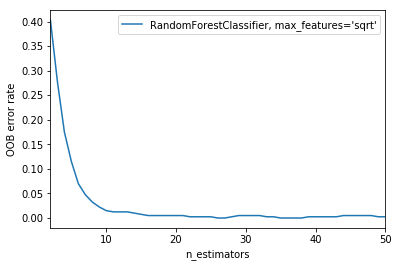

In [166]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


print(__doc__)

RANDOM_STATE = 12

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=50,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE))]
   

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 2
max_estimators = 50

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)


        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()


In [174]:
dfplot = dfMagicMike.groupby(['Source',"Protocol","Source Port","Destination Port"]).Destination.sum().reset_index()
dfplot['Source'] = dfplot['Source'] + '/' + dfplot['DateTime'].map(str)
data_plot = dfplot.sort_values(by='Destination',ascending = False, ).head(80)

KeyError: 'DateTime'

In [168]:
data = [go.Bar(x=data_plot.Source,
            y=data_plot.Destination)
       ]

py.iplot(data, filename='jupyter-basic_bar')

In [169]:


dfplot = dfMagicMike.sort_values(by='DateTime',ascending = True, )
sources = {}
data = []

for index, row in dfplot.iterrows():
    if row['Source'] not in sources:
        info = {}
        times = []
        dests = []
        info['time'] = times
        info['dest'] = dests
        sources[row['Source']] = info
        
    sources[row['Source']]['time'].append(row['DateTime'])
    sources[row['Source']]['dest'].append(row['Destination'])


for source in sources:
    
    trace = go.Scatter(
        x = sources[source]['time'],
        y = sources[source]['dest'],
        mode = 'lines',
        name = source
    )
    data.append(trace)

py.iplot(data, filename='line-mode')



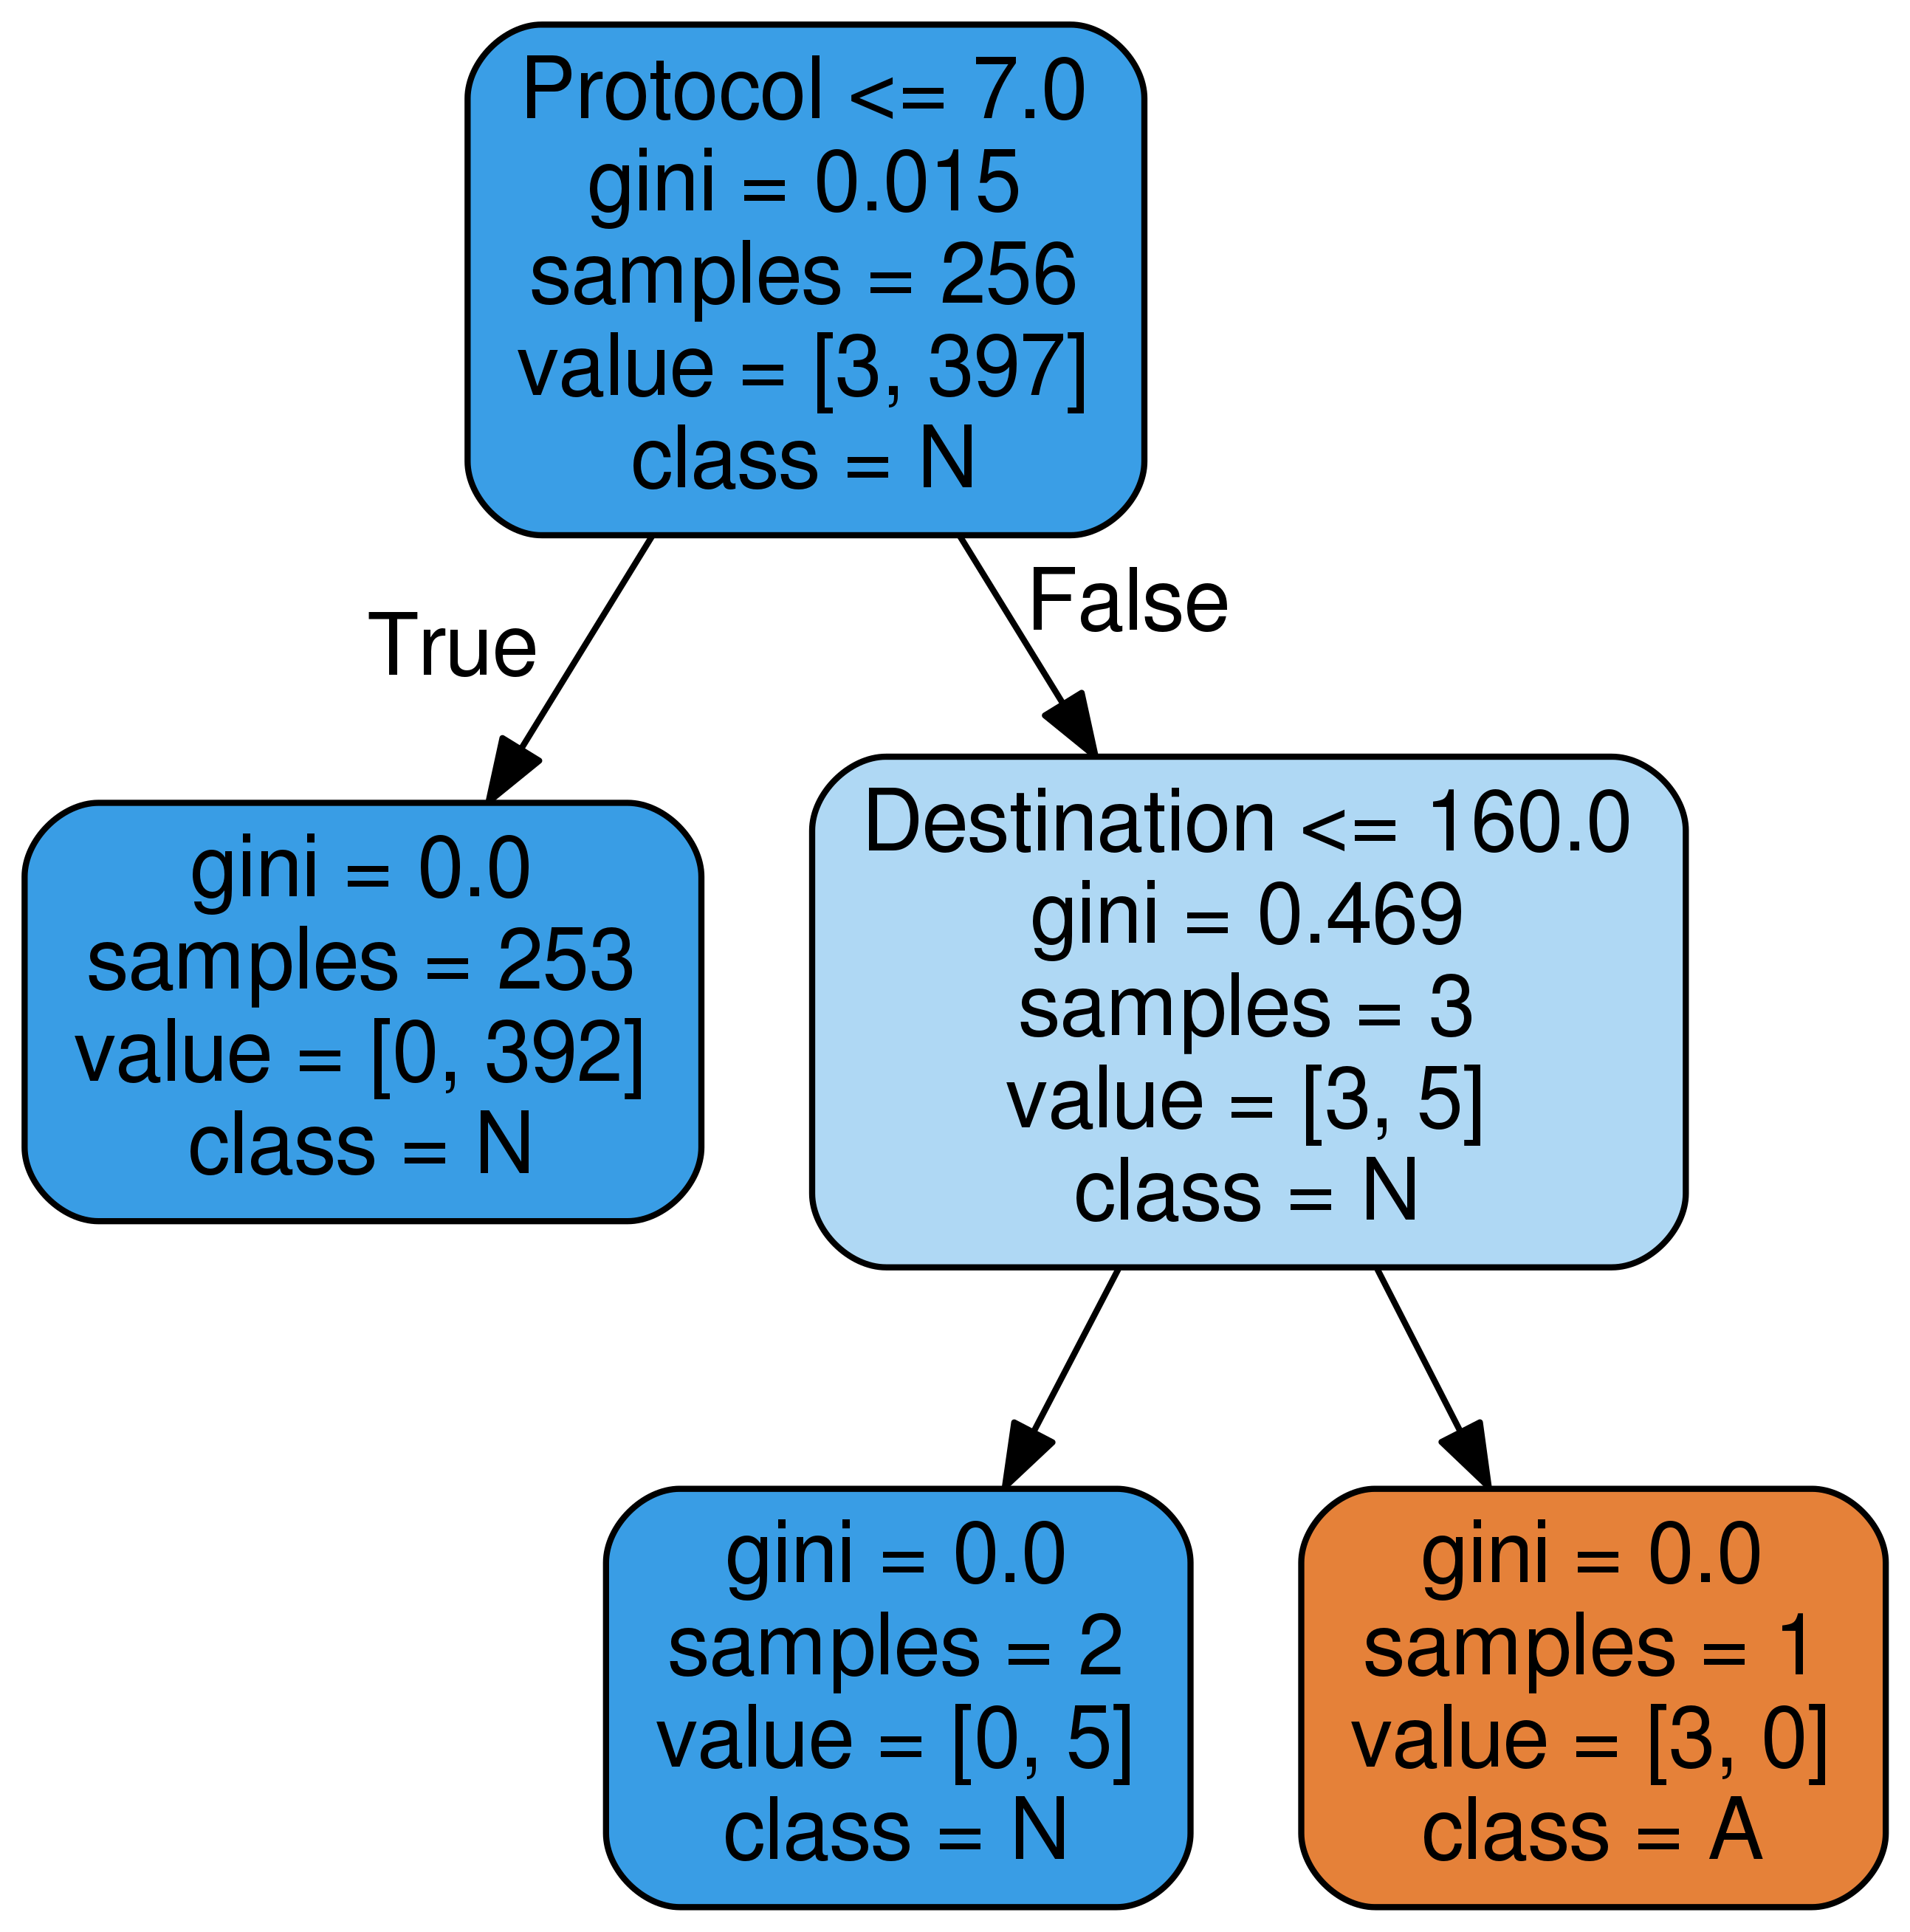

In [170]:
feature = dfMagicMike.label
classnames = dfMagicMike[train_cols]


# Extract single tree
estimator = clf.estimators_[1]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree2.dot', 
                feature_names = classnames.columns.values,
                class_names = feature.to_frame().label.unique(),
                rounded = True, proportion = False, 
                precision = 3, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree2.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

In [171]:
clf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=662124363, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1916507803, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_wei